In [1]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [2]:
import numpy as np
from core.metrics import pmse
from core.linalg_utils import circular_aperture, random_unitary_matrix
from graph.structure.graph import Graph
from graph.prior.support_prior import SupportPrior
from graph.propagator.unitary_propagator import UnitaryPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ ====
n = 256
m = int(3*n)
shape = (m,)
rng = np.random.default_rng(seed=123)
var = 1e-4
U = random_unitary_matrix(m, rng=rng)

# Support mask: center half active
support = np.zeros(shape, dtype=bool)
support[n:2*n] = True

# ==== 2. グラフ定義 ====
class SimplePhaseGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = SupportPrior(support=support)
        self.Y = UnitaryPropagator(U) @ self.X
        self.Z = AmplitudeMeasurement(self.Y, var=var, damping=0.1)
        self.compile()

# ==== 3. 初期化とデータ生成 ====
g = SimplePhaseGraph()
g.set_init_rng(np.random.default_rng(seed=11))

g.generate_sample(rng=np.random.default_rng(seed=999))
true_x = g.X.get_sample()

# 観測データを measurement に設定
g.Z.update_observed_from_sample()

# ==== 4. 推論（Belief Propagation） ====
def monitor(graph, t):
    if t % 20 == 0:
        est = graph.X.compute_belief().data
        err = pmse(est, true_x)
        print(f"[t={t}] PMSE = {err:.3e}")

g.run(n_iter=100, callback=monitor)

# ==== 5. 結果 ====
final_est = g.X.compute_belief().data
final_err = pmse(final_est, true_x)
print(f"\nFinal PMSE after 100 iterations: {final_err:.3e}")

[t=0] PMSE = 7.012e-01
[t=20] PMSE = 3.239e-01
[t=40] PMSE = 1.996e-01
[t=60] PMSE = 1.354e-03
[t=80] PMSE = 2.521e-04

Final PMSE after 100 iterations: 2.516e-04


In [3]:
%prun -l 40 -s cumulative g.run(n_iter=100, callback=monitor)

[t=0] PMSE = 2.516e-04
[t=20] PMSE = 2.516e-04
[t=40] PMSE = 2.516e-04
[t=60] PMSE = 2.516e-04
[t=80] PMSE = 2.516e-04
 

         44333 function calls in 0.089 seconds

   Ordered by: cumulative time
   List reduced from 92 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.089    0.089 {built-in method builtins.exec}
        1    0.000    0.000    0.089    0.089 <string>:1(<module>)
        1    0.000    0.000    0.089    0.089 graph.py:62(run)
      100    0.000    0.000    0.071    0.001 graph.py:57(backward)
      100    0.000    0.000    0.057    0.001 unitary_propagator.py:75(backward)
      100    0.049    0.000    0.053    0.001 unitary_propagator.py:31(compute_belief)
      100    0.000    0.000    0.017    0.000 graph.py:52(forward)
      200    0.000    0.000    0.014    0.000 wave.py:120(forward)
      500    0.006    0.000    0.012    0.000 uncertain_array.py:164(__truediv__)
      100    0.000    0.000    0.012    0.000 base.py:50(backward)
      100    0.000    0.000    0.011    0.000 amplitude_measurement

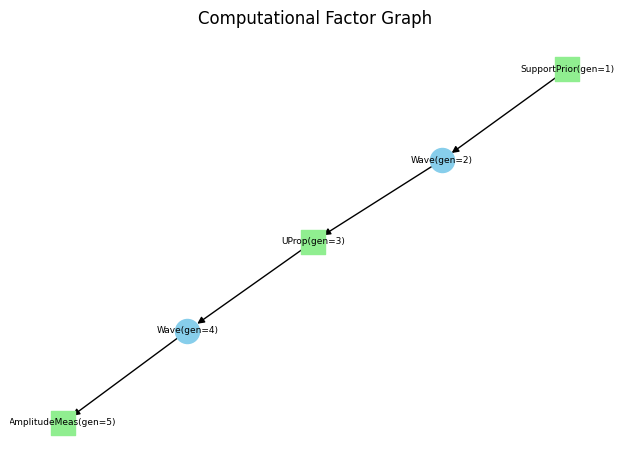

In [4]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

## Sparse Phase Retrieval

In [5]:
import numpy as np
from core.metrics import pmse
from core.linalg_utils import random_unitary_matrix
from graph.structure.graph import Graph
from graph.prior.sparse_prior import SparsePrior
from graph.propagator.unitary_propagator import UnitaryPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ ====
n = 128
rho = 0.2
var = 1e-4
rng = np.random.default_rng(seed=43)
U = random_unitary_matrix(n, rng=rng)

# ==== 2. グラフ定義 ====
class SparsePhaseGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = SparsePrior(rho=rho, shape=(n,), damping=0.3)
        self.Y = UnitaryPropagator(U) @ self.X
        self.Z = AmplitudeMeasurement(self.Y, var=var, damping=0.3)
        self.compile()

# ==== 3. 実行 ====
g = SparsePhaseGraph()
g.set_init_rng(np.random.default_rng(seed=15))
g.generate_sample(rng=np.random.default_rng(seed=99))
true_x = g.X.get_sample()
g.Z.update_observed_from_sample()

# ==== 4. 推論 ====
def monitor(graph, t):
    if t % 100 == 0:
        est = graph.X.compute_belief().data
        err = pmse(est, true_x)
        print(f"[t={t}] PMSE = {err:.3e}")

g.run(n_iter=1000, callback=monitor)

final_est = g.X.compute_belief().data
final_err = pmse(final_est, true_x)
print(f"\nFinal PMSE after 1000 iterations: {final_err:.3e}")

[t=0] PMSE = 3.311e-01
[t=100] PMSE = 1.804e-01
[t=200] PMSE = 1.804e-01
[t=300] PMSE = 1.804e-01
[t=400] PMSE = 1.804e-01
[t=500] PMSE = 1.804e-01
[t=600] PMSE = 1.804e-01
[t=700] PMSE = 1.804e-01
[t=800] PMSE = 1.804e-01
[t=900] PMSE = 1.804e-01

Final PMSE after 1000 iterations: 1.804e-01


## Fourier Phase Retrieval

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from core.metrics import pmse
from core.linalg_utils import circular_aperture
from graph.structure.graph import Graph
from graph.prior.support_prior import SupportPrior
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ設定 ====
H, W = 128, 128
shape = (H, W)
var = 1e-6
support_radius = 0.3
rng = np.random.default_rng(seed=42)

# ==== 2. グラフ定義 ====
class PhaseRetrievalGraph(Graph):
    def __init__(self):
        super().__init__()
        # 2.1 Support mask
        support = circular_aperture(shape, radius=support_radius)
        self.X = SupportPrior(support=support, scalar_precision=False)
        # 2.2 Forward model: FFT only
        self.Y = FFT2DPropagator(shape=shape) @ self.X
        # 2.3 AmplitudeMeasurement (nonlinear)
        self.Z = AmplitudeMeasurement(self.Y, var=var, damping=0.05)
        self.compile()

# ==== 3. 初期化とデータ生成 ====
g = PhaseRetrievalGraph()
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=11))

true_x = g.X.get_sample()
g.Z.update_observed_from_sample()

# ==== 4. 推論（Belief Propagation）====
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = pmse(est, true_x)
    if t % 40 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=400, callback=monitor)
print(1/(support_radius**2 * np.pi))

[t=0] PMSE = 5.80475e-01
[t=40] PMSE = 4.11582e-01
[t=80] PMSE = 4.44008e-01
[t=120] PMSE = 4.75951e-01
[t=160] PMSE = 4.98497e-01
[t=200] PMSE = 5.13834e-01
[t=240] PMSE = 5.24253e-01
[t=280] PMSE = 5.32283e-01
[t=320] PMSE = 5.37397e-01
[t=360] PMSE = 5.40366e-01
3.53677651315323


In [7]:
import numpy as np
import matplotlib.pyplot as plt

from core.metrics import pmse
from core.linalg_utils import circular_aperture, random_phase_mask
from graph.structure.graph import Graph
from graph.prior.support_prior import SupportPrior
from graph.propagator.phase_mask_propagator import PhaseMaskPropagator
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement

# ==== 1. パラメータ ====
H, W = 128, 128
shape = (H, W)
var = 1e-4
support_radius = 0.3
rng = np.random.default_rng(seed=42)

# ==== 2. グラフ定義 ====
class PhaseCodedCDIGraph(Graph):
    def __init__(self):
        super().__init__()

        support = circular_aperture(shape, radius=support_radius)
        self.X = SupportPrior(support=support, scalar_precision=False)

        # Phase mask (adds randomness before FFT)
        phase_mask = random_phase_mask(shape, rng=rng)
        self.Y = PhaseMaskPropagator(phase_mask) @ self.X

        self.F = FFT2DPropagator(shape=shape) @ self.Y

        # Amplitude measurement with Laplace approximation
        self.Z = AmplitudeMeasurement(self.F, var=var, damping=0.3)

        self.compile()

# ==== 3. 初期化とデータ生成 ====
g = PhaseCodedCDIGraph()
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999))
true_x = g.X.get_sample()
g.Z.update_observed_from_sample()

# ==== 4. 推論 ====
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = pmse(est, true_x)
    if t % 10 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=100, callback=monitor)

[t=0] PMSE = 5.58730e-01
[t=10] PMSE = 4.96965e-01
[t=20] PMSE = 5.34579e-01
[t=30] PMSE = 5.36787e-01
[t=40] PMSE = 5.37293e-01
[t=50] PMSE = 5.37473e-01
[t=60] PMSE = 5.37626e-01
[t=70] PMSE = 5.37613e-01
[t=80] PMSE = 5.37653e-01
[t=90] PMSE = 5.38025e-01


In [11]:
# ==== 1. パラメータ ====
H, W = 256, 256
shape = (H, W)
var = 1e-4
support_radius = 0.32
rng = np.random.default_rng(seed=42)

class StructuredRandomGraph(Graph):
    def __init__(self):
        super().__init__()
        support = circular_aperture(shape, radius=support_radius)
        self.X = SupportPrior(support=support, scalar_precision=False)

        # Structured random layers (D₁F D₂F D₃F)
        phase1 = random_phase_mask(shape, rng=rng)
        self.Y1 = PhaseMaskPropagator(phase1) @ self.X
        self.Y2 = FFT2DPropagator(shape=shape) @ self.Y1
        phase2 = random_phase_mask(shape, rng=rng)
        self.Y3 = PhaseMaskPropagator(phase2) @ self.Y2
        self.Y4 = FFT2DPropagator(shape=shape) @ self.Y3
        # Final measurement
        self.Z = AmplitudeMeasurement(self.Y4, var=var, damping=0.3)

        self.compile()

# ==== 3. 初期化とデータ生成 ====
g = StructuredRandomGraph()
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999))
true_x = g.X.get_sample()
g.Z.update_observed_from_sample()

# ==== 4. 推論 ====
def monitor(graph, t):
    est = graph.X.compute_belief().data
    err = pmse(est, true_x)
    if t % 20 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=200, callback=monitor)
print("Oversampling Ration = ", 1/(support_radius**2 * np.pi))

[t=0] PMSE = 6.38548e-01
[t=20] PMSE = 3.28026e-01
[t=40] PMSE = 3.17933e-01
[t=60] PMSE = 3.12909e-01
[t=80] PMSE = 3.08295e-01
[t=100] PMSE = 2.45706e-01
[t=120] PMSE = 3.35101e-04
[t=140] PMSE = 2.49502e-04
[t=160] PMSE = 2.49245e-04
[t=180] PMSE = 2.49245e-04
Oversampling Ration =  3.108494982263581


In [9]:
%prun -l 40 -s cumulative g.run(n_iter=200, callback=monitor)

[t=0] PMSE = 2.49245e-04
[t=20] PMSE = 2.49245e-04
[t=40] PMSE = 2.49245e-04
[t=60] PMSE = 2.49245e-04
[t=80] PMSE = 2.49245e-04
[t=100] PMSE = 2.49245e-04
[t=120] PMSE = 2.49245e-04
[t=140] PMSE = 2.49245e-04
[t=160] PMSE = 2.49245e-04
[t=180] PMSE = 2.49245e-04
 

         263515 function calls in 7.993 seconds

   Ordered by: cumulative time
   List reduced from 134 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    7.993    7.993 {built-in method builtins.exec}
        1    0.000    0.000    7.993    7.993 <string>:1(<module>)
        1    0.001    0.001    7.993    7.993 graph.py:62(run)
      200    0.002    0.000    4.055    0.020 graph.py:52(forward)
      200    0.017    0.000    3.349    0.017 graph.py:57(backward)
     1000    0.007    0.000    3.345    0.003 wave.py:120(forward)
     1200    0.134    0.000    2.591    0.002 wave.py:100(compute_belief)
     2000    2.299    0.001    2.411    0.001 uncertain_array.py:164(__truediv__)
      400    0.017    0.000    2.265    0.006 fft_2d_propagator.py:67(backward)
      400    0.443    0.001    1.729    0.004 fft_2d_propagator.py:25(compute_belief)
     1200    1.303    0.001    1.311    0.001 uncertain_arra

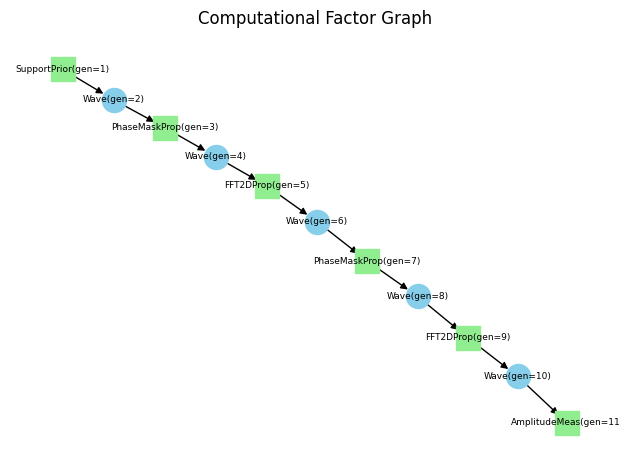

In [10]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)